# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        local_svm = LinearSVM()
        local_svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        acc_train = np.mean(y_train == local_svm.predict(X_train_feats))
        acc_val = np.mean(y_val == local_svm.predict(X_val_feats))     
        results[(lr, reg)] = (acc_train, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_svm = local_svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.093612 val accuracy: 0.091000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.100694 val accuracy: 0.099000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.413980 val accuracy: 0.411000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.101857 val accuracy: 0.107000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.411367 val accuracy: 0.409000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.404673 val accuracy: 0.409000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.412469 val accuracy: 0.400000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.405510 val accuracy: 0.420000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.313327 val accuracy: 0.306000
best validation accuracy achieved during cross-validation: 0.420000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.41


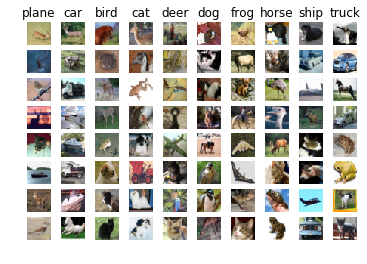

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

**Your answer:** Yes, for example under 'horse' category, there is a cat in it, which makes sense because (1) the picture has similar colour to what an image to a horse would have, and (2) the shape of a cat in this image is similar to the shape of a horse as well. So the misclassifications make sense.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print(X_train_feats.shape)

(49000, 155)


0.6 0.002 0.995
iteration 0 / 2500: loss 2.302588
iteration 100 / 2500: loss 1.450943
iteration 200 / 2500: loss 1.424808
iteration 300 / 2500: loss 1.382735
iteration 400 / 2500: loss 1.450419
iteration 500 / 2500: loss 1.254370
iteration 600 / 2500: loss 1.254433
iteration 700 / 2500: loss 1.235755
iteration 800 / 2500: loss 1.268400
iteration 900 / 2500: loss 1.219351
iteration 1000 / 2500: loss 1.299556
iteration 1100 / 2500: loss 1.233774
iteration 1200 / 2500: loss 1.266457
iteration 1300 / 2500: loss 1.183725
iteration 1400 / 2500: loss 1.293520
iteration 1500 / 2500: loss 1.264109
iteration 1600 / 2500: loss 1.215034
iteration 1700 / 2500: loss 1.210350
iteration 1800 / 2500: loss 1.211787
iteration 1900 / 2500: loss 1.213527
iteration 2000 / 2500: loss 1.196009
iteration 2100 / 2500: loss 1.210434
iteration 2200 / 2500: loss 1.263134
iteration 2300 / 2500: loss 1.163940
iteration 2400 / 2500: loss 1.175978


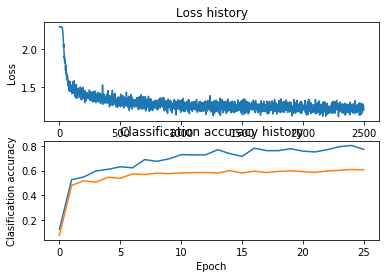

best validation accuracy achieved during cross-validation: 0.608000
Details :-
lr: 0.600000; reg: 0.002000; decay: 0.995000: 0.608000


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 1000
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val = -1

learning_rates = [.6] # 1
learning_rate_decays = [.995]
regularization_strengths = [2e-3] # 2e-3

result = {}

for lr in learning_rates:
    for reg in regularization_strengths:
        for lr_decay in learning_rate_decays:
            # Train the network
            print(lr, reg, lr_decay)
            local_net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            local_stat = local_net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=2500, batch_size=500,
                        learning_rate=lr, learning_rate_decay=lr_decay,
                        reg=reg, verbose=True)
            acc = np.max(local_stat['val_acc_history'])
            result[(lr, reg, lr_decay)] = acc
            if acc > best_val:
                best_val = acc
                best_net = local_net
                
plt.subplot(2, 1, 1)
plt.plot(local_stat['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(local_stat['train_acc_history'], label='train')                
plt.plot(local_stat['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show() 
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('Details :-')
for lr, reg, decay in result:
    print('lr: %f; reg: %f; decay: %f: %f' % (lr, reg, decay, result[(lr, reg, decay)]) )
    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [9]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.591


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

# Bonus 1: Consider only either HoG or Color Histogram in training data

## (a) HoG

In [10]:
### THIS IS BOUNS PART ###
### In this part, I would like to investigate the accuracy of network if I only considered either HoG or color histogram
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
# feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
feature_fns = [hog_feature]
X_train_feats_hog = extract_features(X_train, feature_fns, verbose=True)
X_val_feats_hog = extract_features(X_val, feature_fns)
X_test_feats_hog = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat_hog = np.mean(X_train_feats_hog, axis=0, keepdims=True)
X_train_feats_hog -= mean_feat_hog
X_val_feats_hog -= mean_feat_hog
X_test_feats_hog -= mean_feat_hog

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat_hog = np.std(X_train_feats_hog, axis=0, keepdims=True)
X_train_feats_hog /= std_feat_hog
X_val_feats_hog /= std_feat_hog
X_test_feats_hog /= std_feat_hog

# Preprocessing: Add a bias dimension
X_train_feats_hog = np.hstack([X_train_feats_hog, np.ones((X_train_feats_hog.shape[0], 1))])
X_val_feats_hog = np.hstack([X_val_feats_hog, np.ones((X_val_feats_hog.shape[0], 1))])
X_test_feats_hog = np.hstack([X_test_feats_hog, np.ones((X_test_feats_hog.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

0.6 0.002 0.995
iteration 0 / 1500: loss 2.302588
iteration 100 / 1500: loss 1.564662
iteration 200 / 1500: loss 1.472295
iteration 300 / 1500: loss 1.494320
iteration 400 / 1500: loss 1.417193
iteration 500 / 1500: loss 1.369042
iteration 600 / 1500: loss 1.311980
iteration 700 / 1500: loss 1.388740
iteration 800 / 1500: loss 1.387925
iteration 900 / 1500: loss 1.296546
iteration 1000 / 1500: loss 1.230989
iteration 1100 / 1500: loss 1.372710
iteration 1200 / 1500: loss 1.337492
iteration 1300 / 1500: loss 1.313616
iteration 1400 / 1500: loss 1.296150


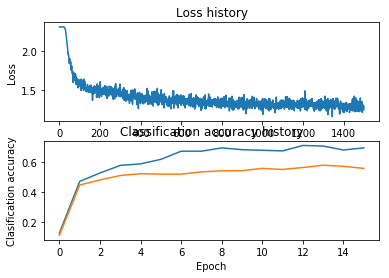

best validation accuracy achieved during cross-validation: 0.577000
Details :-
lr: 0.600000; reg: 0.002000; decay: 0.995000: 0.577000


In [11]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats_hog.shape[1]
hidden_dim = 1000
num_classes = 10

best_net_hog = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val_hog = -1

learning_rates = [.6] # 1
learning_rate_decays = [.995]
regularization_strengths = [2e-3] # 2e-3

result_hog = {}

for lr in learning_rates:
    for reg in regularization_strengths:
        for lr_decay in learning_rate_decays:
            # Train the network
            print(lr, reg, lr_decay)
            local_net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            local_stat_hog = local_net.train(X_train_feats_hog, y_train, X_val_feats_hog, y_val,
                        num_iters=1500, batch_size=500,
                        learning_rate=lr, learning_rate_decay=lr_decay,
                        reg=reg, verbose=True)
            acc = np.max(local_stat_hog['val_acc_history'])
            result_hog[(lr, reg, lr_decay)] = acc
            if acc > best_val_hog:
                best_val_hog = acc
                best_net_hog = local_net
                
plt.subplot(2, 1, 1)
plt.plot(local_stat_hog['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(local_stat_hog['train_acc_history'], label='train')                
plt.plot(local_stat_hog['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show() 
    
print('best validation accuracy achieved during cross-validation: %f' % best_val_hog)
print('Details :-')
for lr, reg, decay in result_hog:
    print('lr: %f; reg: %f; decay: %f: %f' % (lr, reg, decay, result_hog[(lr, reg, decay)]) )
    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [12]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc_hog = (best_net_hog.predict(X_test_feats_hog) == y_test).mean()
print(test_acc_hog)

0.565


## (b) Color Histogram

In [13]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
# feature_fns = [hsv_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
feature_fns = [lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats_hsv = extract_features(X_train, feature_fns, verbose=True)
X_val_feats_hsv = extract_features(X_val, feature_fns)
X_test_feats_hsv = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat_hsv = np.mean(X_train_feats_hsv, axis=0, keepdims=True)
X_train_feats_hsv -= mean_feat_hsv
X_val_feats_hsv -= mean_feat_hsv
X_test_feats_hsv -= mean_feat_hsv

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat_hsv = np.std(X_train_feats_hsv, axis=0, keepdims=True)
X_train_feats_hsv /= std_feat_hsv
X_val_feats_hsv /= std_feat_hsv
X_test_feats_hsv /= std_feat_hsv

# Preprocessing: Add a bias dimension
X_train_feats_hsv = np.hstack([X_train_feats_hsv, np.ones((X_train_feats_hsv.shape[0], 1))])
X_val_feats_hsv = np.hstack([X_val_feats_hsv, np.ones((X_val_feats_hsv.shape[0], 1))])
X_test_feats_hsv = np.hstack([X_test_feats_hsv, np.ones((X_test_feats_hsv.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

0.6 0.002 1
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.080690
iteration 200 / 1500: loss 2.068238
iteration 300 / 1500: loss 2.056954
iteration 400 / 1500: loss 2.053916
iteration 500 / 1500: loss 2.002789
iteration 600 / 1500: loss 2.067994
iteration 700 / 1500: loss 2.038975
iteration 800 / 1500: loss 1.978695
iteration 900 / 1500: loss 2.033358
iteration 1000 / 1500: loss 1.946452
iteration 1100 / 1500: loss 2.035775
iteration 1200 / 1500: loss 2.008691
iteration 1300 / 1500: loss 2.041724
iteration 1400 / 1500: loss 2.013559


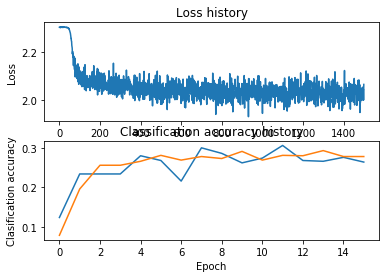

best validation accuracy achieved during cross-validation: 0.293000
Details :-
lr: 0.600000; reg: 0.002000; decay: 1.000000: 0.293000


In [14]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats_hsv.shape[1]
hidden_dim = 1000
num_classes = 10

best_net_hsv = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val_hsv = -1

learning_rates = [.6] # 1
learning_rate_decays = [1]
regularization_strengths = [2e-3] # 2e-3

result_hsv = {}

for lr in learning_rates:
    for reg in regularization_strengths:
        for lr_decay in learning_rate_decays:
            # Train the network
            print(lr, reg, lr_decay)
            local_net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            local_stat_hsv = local_net.train(X_train_feats_hsv, y_train, X_val_feats_hsv, y_val,
                        num_iters=1500, batch_size=500,
                        learning_rate=lr, learning_rate_decay=lr_decay,
                        reg=reg, verbose=True)
            acc = np.max(local_stat_hsv['val_acc_history'])
            result_hsv[(lr, reg, lr_decay)] = acc
            if acc > best_val_hsv:
                best_val_hsv = acc
                best_net_hsv = local_net
                
plt.subplot(2, 1, 1)
plt.plot(local_stat_hsv['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(local_stat_hsv['train_acc_history'], label='train')                
plt.plot(local_stat_hsv['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show() 
    
print('best validation accuracy achieved during cross-validation: %f' % best_val_hsv)
print('Details :-')
for lr, reg, decay in result_hsv:
    print('lr: %f; reg: %f; decay: %f: %f' % (lr, reg, decay, result_hsv[(lr, reg, decay)]) )
    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [15]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc_hsv = (best_net_hsv.predict(X_test_feats_hsv) == y_test).mean()
print(test_acc_hsv)

0.257


It seems that using only HoG I can get a similar result to the one using both features. Though, for the only using color histogram, I had a hard time reducing the loss below 2. I think using only color histogram is not a good feature, beacuse multiple objects can have similar color distributions (as seen in KNN python notebook). Therefore, this model is more difficult to converge.

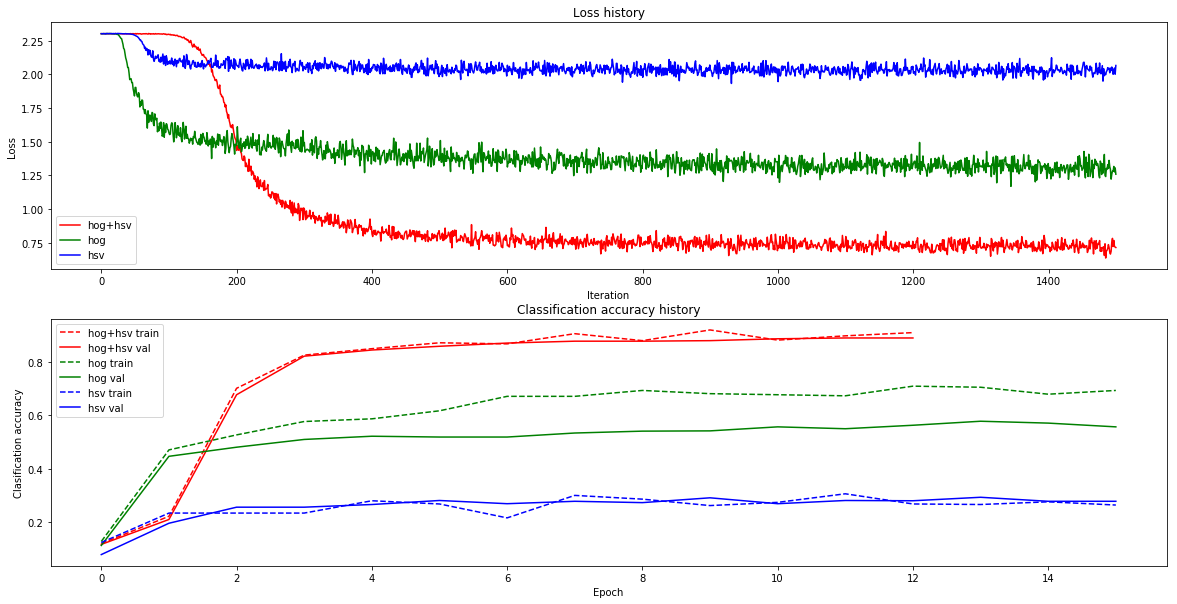

In [54]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)

plt.plot(local_stat['loss_history'], 'r', label='hog+hsv')
plt.plot(local_stat_hog['loss_history'], 'g', label='hog')
plt.plot(local_stat_hsv['loss_history'], 'b', label='hsv')

plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(local_stat['train_acc_history'],  'r--', label='hog+hsv train')                
plt.plot(local_stat['val_acc_history'],  'r', label='hog+hsv val')
plt.plot(local_stat_hog['train_acc_history'],  'g--', label='hog train')                
plt.plot(local_stat_hog['val_acc_history'],  'g', label='hog val')
plt.plot(local_stat_hsv['train_acc_history'], 'b--', label='hsv train')                
plt.plot(local_stat_hsv['val_acc_history'],  'b', label='hsv val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show() 

# Bonus 2: Using TwoLayerNet to train MNIST
This is one of the challenges I encountered in CodeIT 2018 the weekend before this assignment submission deadline. Since I completed that challenge by TwoLayerNet in this assignment, I might as well just post my code here. tensorflow is used here just for downloading the MNIST pack.

FYI: The challenge requires an accuracy of 90%+, and a timeout of 10 seconds. So instead of training network on the spot after receiving data, I trained the network, saved down the parameters, and just loaded them up whenever they were needed.

In [23]:
import tensorflow as tf
import numpy as np

tf.keras.backend.clear_session()
mnist = tf.keras.datasets.mnist

# Download data -- only place where tf is called
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Normalized data to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten
x_train = x_train.reshape([x_train.shape[0], -1])

# Select first 1000 images as validation set
x_val = x_train[:1000]
y_val = y_train[:1000]
x_train = x_train[1000:]
y_train = y_train[1000:]

# Flatten
x_test = x_test.reshape([x_test.shape[0], -1])

from cs231n.classifiers.neural_net import TwoLayerNet
result = {}
best_val = -1
best_softmax = None
learning_rates = [1e-1]
learning_rate_decays = [.94]
regularization_strengths = [1e-2]

for lr in learning_rates:
    for reg in regularization_strengths:
        for lr_decay in learning_rate_decays:
            # Train the network
            print(lr, reg, lr_decay)
            local_net = TwoLayerNet(28*28, 256, 10) # Input: 28x28, Hidden Size: 256, Output: 10 categories
            local_stat = local_net.train(x_train, y_train, x_val, y_val,
                        num_iters=1500, batch_size=500,
                        learning_rate=lr, learning_rate_decay=lr_decay,
                        reg=reg, verbose=True)
            acc = np.max(local_stat['val_acc_history'])
            result[(lr, reg, lr_decay)] = acc
            if acc > best_val:
                best_val = acc

# Print out results.
for lr, reg, decay in result:
    print('lr: %f; reg: %f; decay: %f: %f' % (lr, reg, decay, result[(lr, reg, decay)]) )

print('best validation accuracy achieved during cross-validation: %f' % best_val)

eva = local_net.predict(x_test)
print('Accuracy:', np.mean(eva - y_test == 0) )


0.1 0.01 0.94
iteration 0 / 1500: loss 2.302606
iteration 100 / 1500: loss 2.296897
iteration 200 / 1500: loss 1.434996
iteration 300 / 1500: loss 0.999888
iteration 400 / 1500: loss 0.813559
iteration 500 / 1500: loss 0.807797
iteration 600 / 1500: loss 0.727556
iteration 700 / 1500: loss 0.777080
iteration 800 / 1500: loss 0.730250
iteration 900 / 1500: loss 0.707317
iteration 1000 / 1500: loss 0.728945
iteration 1100 / 1500: loss 0.795455
iteration 1200 / 1500: loss 0.730574
iteration 1300 / 1500: loss 0.708634
iteration 1400 / 1500: loss 0.713566
lr: 0.100000; reg: 0.010000; decay: 0.940000: 0.888000
best validation accuracy achieved during cross-validation: 0.888000
Accuracy: 0.9019


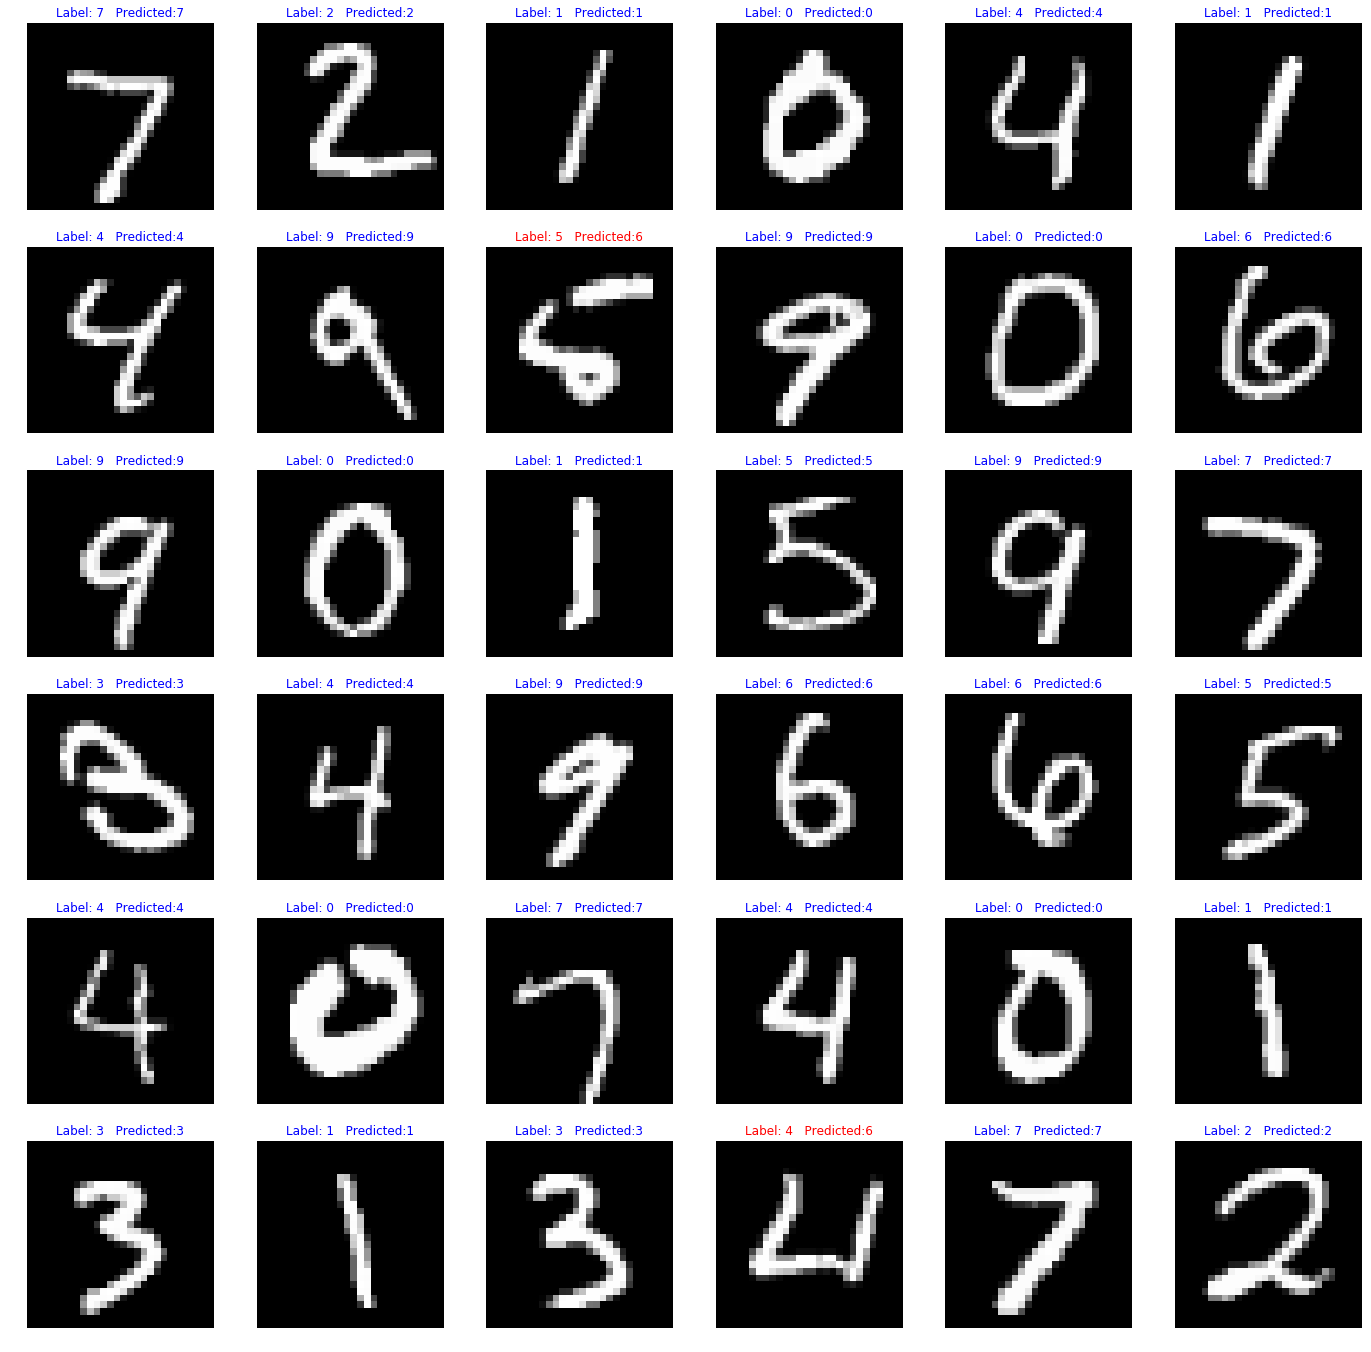

In [50]:
num_rows = 6
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*2*num_rows))
# Plotting the results of first n*m images
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.axis('off')
    plt.imshow(x_test[i].reshape(28,28))
    color = 'blue' if y_test[i] == eva[i] else 'red'
    plt.title('Label: ' + str(y_test[i]) + '   Predicted:' + str(eva[i]), color=color)


The incorrect cases are when the integers are more illegible, hence, the model is predicting very well.